In [1]:
import numpy as np
from paik.solver import Solver, DEFAULT_SOLVER_PARAM_M7_NORM

solver = Solver(solver_param=DEFAULT_SOLVER_PARAM_M7_NORM)

WorldModel::LoadRobot: /home/luca/.cache/jrl/temp_urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link4.dae (43520 verts, 14620 tris)
LoadAssimp: Loaded model /ho

In [2]:
num_poses = 1
num_sols = 10000

solver.shrink_ratio = 0.0
J, P, F = solver.get_random_JPF(num_samples=num_poses)

In [3]:
avg_pos, avg_ori = solver.random_sample_solutions_with_evaluation(
    num_poses=100, num_sols=100
)
avg_pos, avg_ori

model inference time: 0.788
calculation errors time: 0.20799999999999996


(0.00409362985039085, 0.05523182392120361)

In [4]:
l2_errs = np.zeros((num_poses, num_sols))
ang_errs = np.zeros((num_poses, num_sols))
config_errs = np.zeros((num_poses, num_sols, 7))
config = np.empty((num_poses, num_sols, 7))

pivot = np.random.randint(0, num_sols)

for i, p in enumerate(P):
    F = np.random.rand(num_sols, 1)
    p = np.tile(p, (num_sols, 1))
    J = solver.solve(P=p, F=F, num_sols=1, return_numpy=True)
    config[i] = J.reshape((num_sols, 7))
    l2_errs[i], ang_errs[i] = solver.evaluate_solutions(J, p, return_col=True)
    config_errs[i] = np.abs(config[i] - config[i, pivot])

In [5]:
import pandas as pd

df = pd.DataFrame(
    {
        "l2_errs": l2_errs.flatten(),
        "ang_errs": ang_errs.flatten(),
        "config_errs": config_errs.mean(-1).flatten(),
    }
)

df.describe(), df.query(f"l2_errs < {avg_pos}").describe()

(            l2_errs      ang_errs   config_errs
 count  10000.000000  10000.000000  10000.000000
 mean       0.684357      1.664277      3.078865
 std        0.545449      0.987264      1.486614
 min        0.001638      0.006515      0.000000
 25%        0.059399      0.708451      2.140899
 50%        0.703843      1.777736      3.017987
 75%        1.274864      2.596310      4.474493
 max        1.488197      3.141433      5.119551,
           l2_errs    ang_errs  config_errs
 count  349.000000  349.000000   349.000000
 mean     0.003077    0.036563     3.238201
 std      0.000785    0.016779     0.234027
 min      0.001638    0.006515     2.779263
 25%      0.002352    0.020991     3.311928
 50%      0.003414    0.042197     3.329164
 75%      0.003737    0.050580     3.356905
 max      0.004087    0.059592     3.670949)

Text(0.5, 0, 'Config Error (rads)')

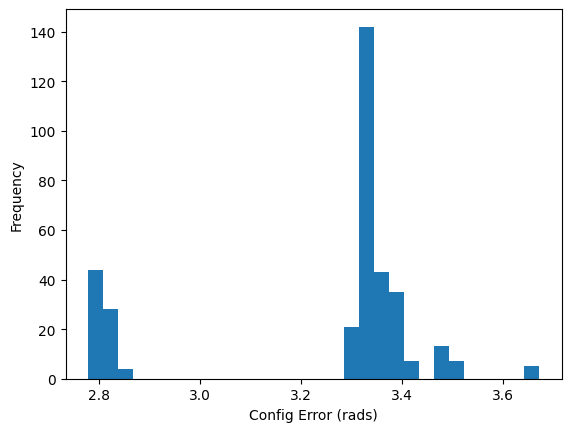

In [6]:
ax = df.query(f"l2_errs < {avg_pos}")["config_errs"].plot.hist(bins=30)
ax.set_xlabel("Config Error (rads)")